# 4. Image Classification: Interpreting Visual Features

## 4.4 Adversarial masks: general attacks from weights (Outer Edge)

### NOTES

This notebook uses code from the [original author’s repository](https://github.com/tdooms/bilinear-interp) to reproduce results.  
We refer to [this code](https://github.com/tdooms/bilinear-interp/blob/main/_old/workspace/mnist/adversarial_outer_edge.ipynb) for the implementation used in this notebook.

In [1]:
# Add root to the sys.path

import sys
from pathlib import Path

ROOT = Path().resolve().parents[1]
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import *
from mpl_toolkits.axes_grid1 import ImageGrid

from image import MNIST, Model

color = dict(color_continuous_scale="RdBu", range_color=[-0.25, 0.25])

/Users/shidqietaufiqurrahman/workspace/miniconda3/envs/fact-ai/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/shidqietaufiqurrahman/workspace/miniconda3/envs/fact-ai/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <063DD42B-A1DA-3BBE-AD5E-03C12F7E3DBA> /Users/shidqietaufiqurrahman/workspace/miniconda3/envs/fact-ai/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/shidqietaufiqurrahman/workspace/miniconda3/envs/fact-ai/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/shidqietaufiqurrahman/workspace/miniconda3/envs/fact-ai/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/shidqietaufiqurrahman/workspace/miniconda3/envs/fact-ai/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/shidqietaufiqurrahman/workspace/mi

In [3]:
# Single-layer MNIST training
torch.set_grad_enabled(True)

# The input norm is about 0.3, so we scale the input noise to 1.0, same as the previous implementation
model = Model.from_config(
    epochs=30, wd=0.0, noise=0.0, n_layer=1, residual=True, device="cpu", seed=42
)

train, test = (
    MNIST(train=True, download=True, device="cpu"),
    MNIST(train=False, download=True, device="cpu"),
)
metrics = model.fit(train, test)

torch.set_grad_enabled(False)
model.to("cpu")

train/loss: 0.027, train/acc: 0.993, val/loss: 0.090, val/acc: 0.975: 100%|██████████| 30/30 [00:14<00:00,  2.10it/s]


Model(
  (embed): Linear(
    in_features=784, out_features=256, bias=False
    (gate): Identity()
  )
  (blocks): ModuleList(
    (0): Bilinear(
      in_features=256, out_features=512, bias=False
      (gate): Identity()
    )
  )
  (head): Linear(
    in_features=256, out_features=10, bias=False
    (gate): Identity()
  )
  (criterion): CrossEntropyLoss()
)

### Figure 7A: Adversarial mask constructed from the given eigenvector along for models trained (Outer Edge)

#### Outer Edge Adversarial Masks

##### Find encoders for eigenvectors
We approximate the encoder as the pseudoinverse of the set of top positive eigenvectors

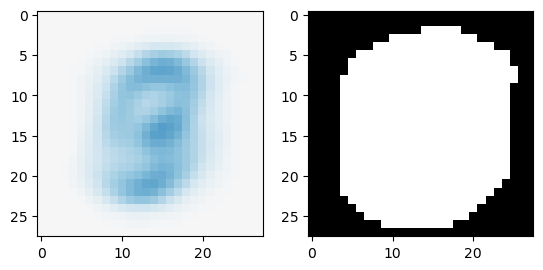

In [4]:
threshold = 0.01
pix_means = train.x.mean(dim=0).cpu()
pix_mask = (pix_means < threshold).float()

plt.subplot(1, 2, 1)
plt.imshow(pix_means.view(28, 28), cmap="RdBu", vmin=-1, vmax=1)
plt.subplot(1, 2, 2)
plt.imshow(pix_mask.float().view(28, 28), cmap="Grays")

In [5]:
# Pseudo-inverse eigenvectors
l, r = model.w_l.squeeze(0), model.w_r.squeeze(0)

b = einsum(model.w_u, l, r, "cls out, out in1, out in2 -> cls in1 in2")
b = 0.5 * (b + b.mT)  # B tensor

eigvals, eigvecs = torch.linalg.eigh(b)
eigvecs = rearrange(eigvecs, "cls model eig -> cls eig model")

topk_per_sign = 10
decoders = eigvecs[:, -topk_per_sign:]

encoders = torch.linalg.pinv(rearrange(decoders, "cls eig model -> (cls eig) model"))
encoders = rearrange(encoders, "model (cls eig) -> cls eig model", cls=10)

encoders_input = einsum(encoders, model.w_e, "cls eig model, model pix -> cls eig pix")
decoders_input = einsum(decoders, model.w_e, "cls eig model, model pix -> cls eig pix")

encoders_input *= pix_mask.view(-1)[None, None, :]

# set signs
data = torch.stack([test.x[test.y == i][:500] for i in range(10)], dim=0)
data = data.cpu()

overlaps = einsum(
    encoders_input,
    data.view(10, 500, -1),
    "digit1 eig pix, digit2 sample pix -> digit1 eig sample digit2",
)
mask = 1 - torch.eye(10)
overlaps = overlaps * mask[:, None, None, :]
signs = overlaps.sum(dim=-1).sum(dim=-1).sign()

encoders_input *= signs[:, :, None]
decoders_input *= signs[:, :, None]

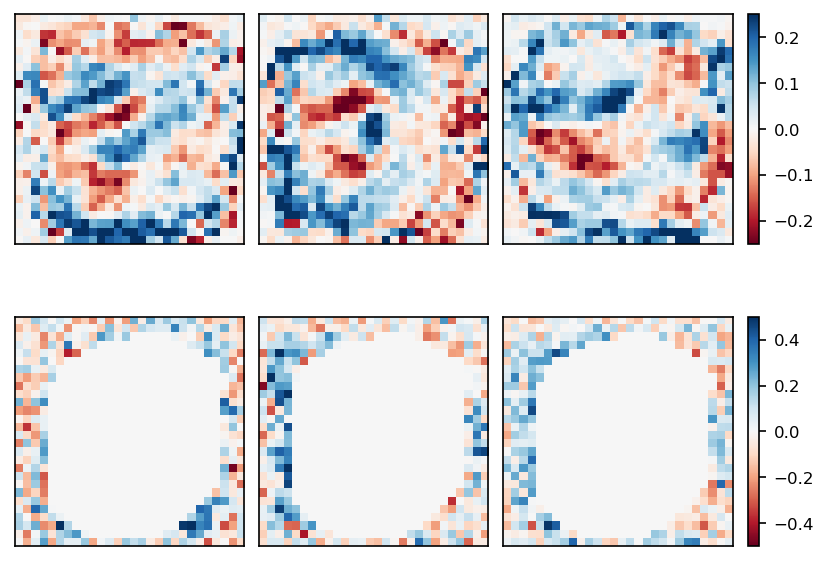

In [6]:
digit = 3
fig = plt.figure(dpi=150)

idxs = torch.arange(-3, 0).flip(0)
num = len(idxs)

grid = ImageGrid(
    fig,
    211,
    nrows_ncols=(1, num),
    axes_pad=0.1,
    cbar_location="right",
    cbar_mode="single",
)
for i in range(num):
    im = grid[i].imshow(
        decoders_input[digit, idxs[i]].view(28, 28), cmap="RdBu", vmin=-0.25, vmax=0.25
    )
    grid[i].set_xticks([])
    grid[i].set_yticks([])
grid.cbar_axes[0].colorbar(im)
grid.cbar_axes[0].tick_params(labelsize=8)

grid = ImageGrid(
    fig,
    212,
    nrows_ncols=(1, num),
    axes_pad=0.1,
    cbar_location="right",
    cbar_mode="single",
)
for i in range(num):
    im = grid[i].imshow(
        encoders_input[digit, idxs[i]].view(28, 28), cmap="RdBu", vmin=-0.5, vmax=0.5
    )
    grid[i].set_xticks([])
    grid[i].set_yticks([])
grid.cbar_axes[0].colorbar(im)
grid.cbar_axes[0].tick_params(labelsize=8)

plt.show()

##### Example for single input

torch.Size([1, 28, 28]) torch.Size([784])


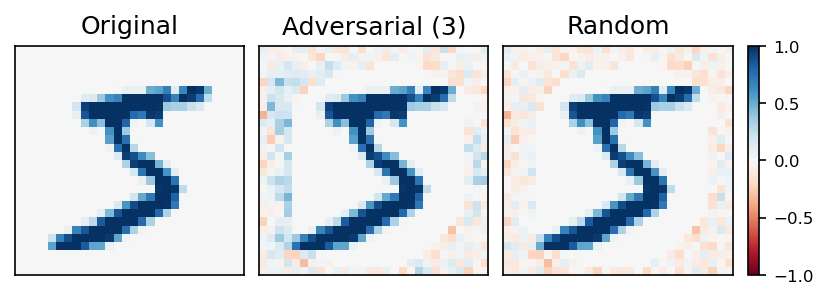

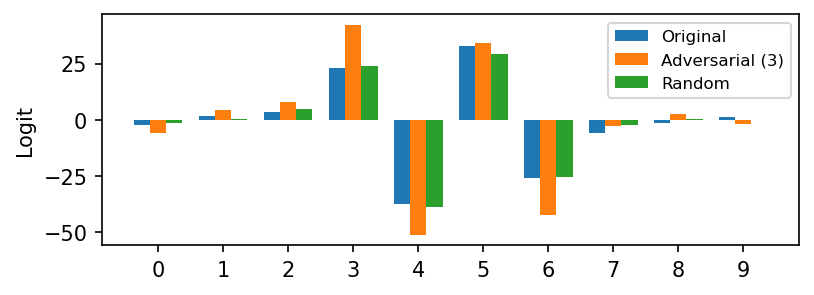

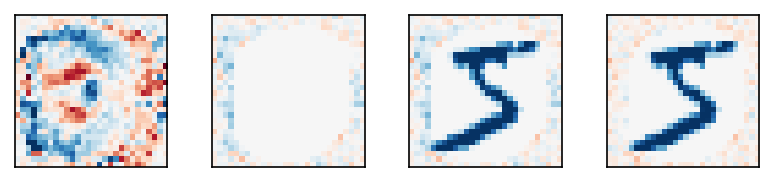

In [7]:
digit = 3
eig_idx = -2
strength = 0.1

mask = encoders_input[digit, eig_idx]
mask /= mask[mask > 0].std(dim=-1)
mask = strength * mask

idx = 0
input = train.x[idx].cpu()

print(input.shape, mask.shape)
in_adv = input + mask.view_as(input)
mask_rand = mask.clone()
mask_rand[mask_rand > 0] = strength * torch.randn((mask_rand > 0).sum())

in_rand = input + mask_rand.view_as(input)
inputs = [input, in_adv, in_rand]
labels = ["Original", f"Adversarial ({digit})", "Random"]

fig = plt.figure(dpi=150)
grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(1, 3),
    axes_pad=0.1,
    cbar_location="right",
    cbar_mode="single",
)
for i, x in enumerate(inputs):
    im = grid[i].imshow(x.view(28, 28), cmap="RdBu", vmin=-1, vmax=1)
    grid[i].set_title(labels[i])
    grid[i].set_xticks([])
    grid[i].set_yticks([])
grid.cbar_axes[0].colorbar(im)
grid.cbar_axes[0].tick_params(labelsize=8)

logits = []
for x in inputs:
    logits.append(model.eval()(x.flatten().unsqueeze(0)))

fig = plt.figure(figsize=(6, 2), dpi=150)
width = 0.25
for i in range(len(inputs)):
    x = np.arange(len(logits[0].flatten())) + (i - 1) * width
    plt.bar(x, logits[i].cpu().numpy().flatten(), width=width, label=labels[i])
plt.legend(prop={"size": 8})
plt.xticks(range(10))
# plt.xlabel('Digit')
plt.ylabel("Logit")

eigenv = (
    decoders_input[digit, eig_idx] * 3
)  # for visualization purpose scale eigenvector
input_final = [eigenv, mask, in_adv, in_rand]

fig = plt.figure(dpi=150)
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.3)
for i, x in enumerate(input_final):
    im = grid[i].imshow(x.view(28, 28), cmap="RdBu", vmin=-1, vmax=1)
    grid[i].set_xticks([])
    grid[i].set_yticks([])


##### Evaluate over adversarial masks

In [8]:
def evaluate_mask(mask, digit, strength):
    inputs = train.x.cpu()

    mask_rand = mask.clone()
    mask_rand[mask_rand > 0] = strength * torch.randn((mask_rand > 0).sum())

    print(inputs.shape, mask.shape)
    logits_list = [
        model.eval().forward(inputs),  # original
        model.eval().forward(inputs + mask.unsqueeze(0)),  # adversarial
        model.eval().forward(inputs + mask_rand.unsqueeze(0)),  # random
    ]
    labels = ["orig", "adv", "rand"]

    metrics = {}
    for logits, label in zip(logits_list, labels):
        metrics[f"avg_logits_{label}"] = logits.mean(dim=0)
        metrics[f"accuracy_{label}"] = (
            (logits.argmax(dim=-1) == train.y.cpu()).float().mean()
        )
        metrics[f"misclassify_rate_{label}"] = (
            ((logits.argmax(dim=-1) == digit) & (train.y.cpu() != digit)).float().mean()
        )
    return metrics

In [9]:
from collections import defaultdict

strengths = np.arange(0.025, 0.301, 0.025)
digits = range(10)
eig_idxs = [-1, -2, -3]


def func():
    return torch.zeros(len(digits), len(eig_idxs), len(strengths))


eval_metrics = defaultdict(func)
for digit in range(10):
    for e, eig_idx in enumerate(eig_idxs):
        for s, strength in enumerate(strengths):
            strength = np.round(strength, 3)
            mask = encoders_input[digit, eig_idx]
            mask /= mask[mask > 0].std(dim=-1, keepdim=True)
            mask = strength * mask
            mask = mask.view(1, 28, 28)
            metrics = evaluate_mask(mask, digit, strength)
            print(
                (
                    digit,
                    eig_idx,
                    strength,
                    metrics["accuracy_adv"],
                    metrics["misclassify_rate_adv"],
                )
            )

            for key in metrics.keys():
                if key.startswith("avg_logits"):
                    continue
                eval_metrics[key][digit, e, s] = metrics[key]

torch.Size([60000, 1, 28, 28]) torch.Size([1, 28, 28])
(0, -1, np.float64(0.025), tensor(0.9859), tensor(0.0002))
torch.Size([60000, 1, 28, 28]) torch.Size([1, 28, 28])
(0, -1, np.float64(0.05), tensor(0.9628), tensor(0.0003))
torch.Size([60000, 1, 28, 28]) torch.Size([1, 28, 28])
(0, -1, np.float64(0.075), tensor(0.9141), tensor(0.0004))
torch.Size([60000, 1, 28, 28]) torch.Size([1, 28, 28])
(0, -1, np.float64(0.1), tensor(0.8379), tensor(0.0006))
torch.Size([60000, 1, 28, 28]) torch.Size([1, 28, 28])
(0, -1, np.float64(0.125), tensor(0.7535), tensor(0.0007))
torch.Size([60000, 1, 28, 28]) torch.Size([1, 28, 28])
(0, -1, np.float64(0.15), tensor(0.6809), tensor(0.0009))
torch.Size([60000, 1, 28, 28]) torch.Size([1, 28, 28])
(0, -1, np.float64(0.175), tensor(0.6183), tensor(0.0011))
torch.Size([60000, 1, 28, 28]) torch.Size([1, 28, 28])
(0, -1, np.float64(0.2), tensor(0.5689), tensor(0.0012))
torch.Size([60000, 1, 28, 28]) torch.Size([1, 28, 28])
(0, -1, np.float64(0.225), tensor(0.527

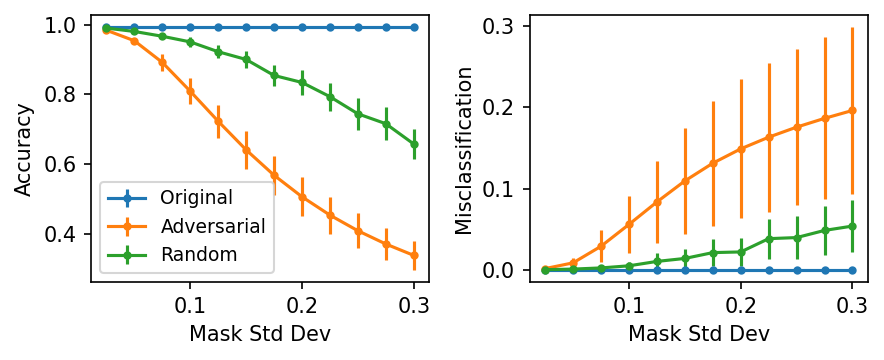

In [10]:
plt.figure(figsize=(6, 2.5), dpi=150)

plt.subplot(1, 2, 1)
keys = ["accuracy_orig", "accuracy_adv", "accuracy_rand"]
labels = ["Original", "Adversarial", "Random"]
for key, label in zip(keys, labels):
    values = eval_metrics[key].view(-1, len(strengths))
    means = values.mean(0)
    stds = values.std(0) / np.sqrt(values.shape[0])
    plt.errorbar(
        strengths, means, yerr=1.96 * stds, fmt="o-", markersize=3, label=label
    )
plt.xlabel("Mask Std Dev")
plt.ylabel("Accuracy")
# plt.title('Accuracy')
plt.legend(prop={"size": 9})

plt.subplot(1, 2, 2)
keys = ["misclassify_rate_orig", "misclassify_rate_adv", "misclassify_rate_rand"]
for key, label in zip(keys, labels):
    values = eval_metrics[key].view(-1, len(strengths))
    means = values.mean(0)
    stds = values.std(0) / np.sqrt(values.shape[0])
    plt.errorbar(
        strengths, means, yerr=1.96 * stds, fmt="o-", markersize=3, label=label
    )
plt.xlabel("Mask Std Dev")
plt.ylabel("Misclassification")
# plt.title('Misclassification as Adversary')

plt.tight_layout()
plt.show()